# Regression from ch 4

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
import pymc3 as pm
import pandas as pd

%matplotlib inline
sns.set(font_scale=1.5)

Text(0.5, 0, '$y$')

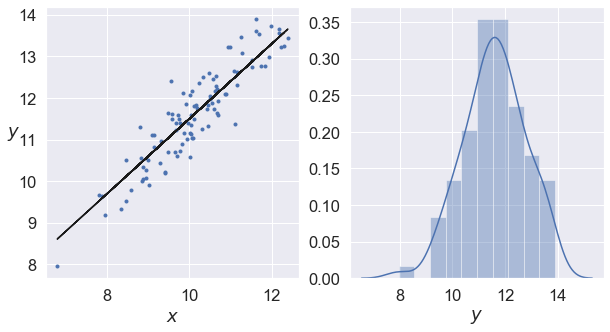

In [19]:
np.random.seed(314)
N = 100
alfa_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)
x = np.random.normal(10, 1, N)
y_real = alfa_real + beta_real * x
y = y_real + eps_real
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(x, y, 'b.')
plt.xlabel('$x$', )
plt.ylabel('$y$', rotation=0)
plt.plot(x, y_real, 'k')
plt.subplot(1,2,2)
sns.distplot(y)
plt.xlabel('$y$')

In [20]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    #mu = pm.Deterministic('mu', alpha + beta * x)
    #y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    y_pred = pm.Normal('y_pred', mu= alpha + beta * x, sd=epsilon, observed=y)
    step = pm.Metropolis()
    trace = pm.sample(10000, step=step, chains=2)

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>Metropolis: [epsilon]
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:05<00:00, 3939.44draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


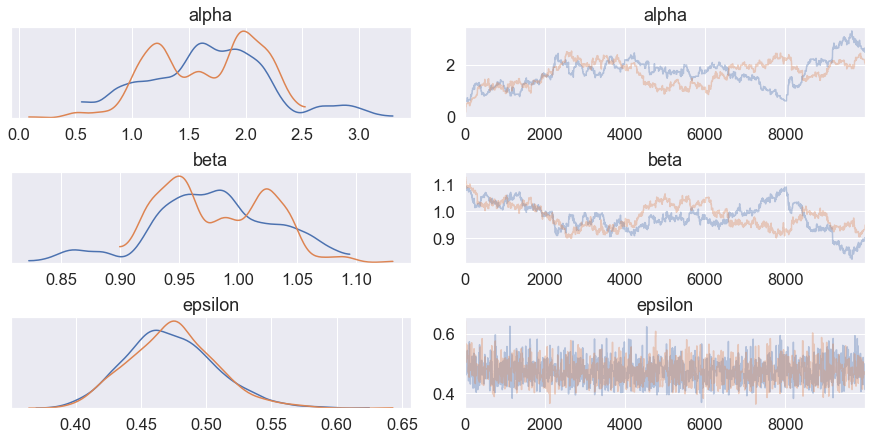

In [21]:
pm.traceplot(trace, compact=True);

### This slow wandering in alpha and beta shows an issue!

In [5]:
pm.summary(trace, var_names=('alpha', 'beta', 'epsilon'))

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,1.669461,0.503898,0.049108,0.581843,2.479340,17.580114,1.001585
beta,0.980660,0.049421,0.004812,0.904448,1.090076,17.622857,1.001567
epsilon,0.473785,0.033953,0.000954,0.410031,0.541577,1324.606066,1.000454


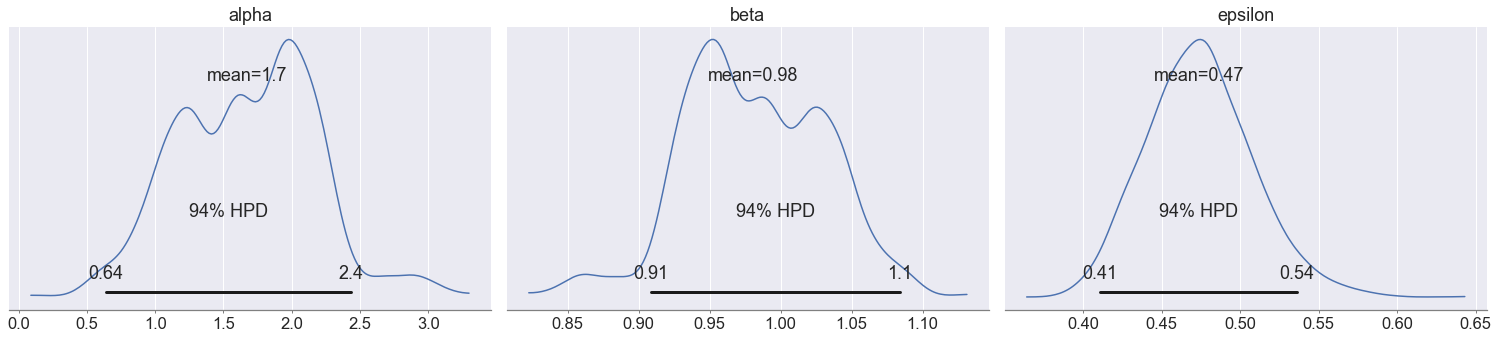

In [6]:
pm.plot_posterior(trace, var_names=('alpha', 'beta', 'epsilon'));

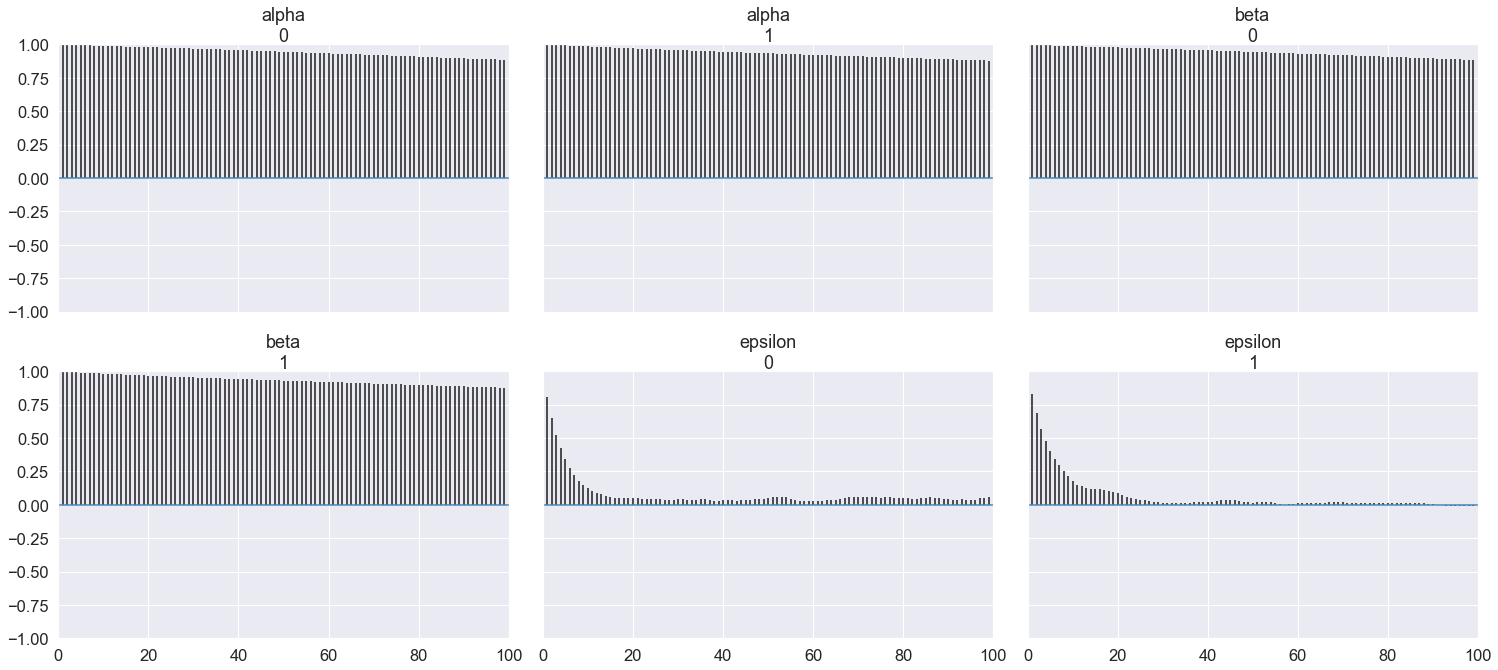

In [7]:
pm.autocorrplot(trace, var_names=('alpha', 'beta', 'epsilon'));

Text(0, 0.5, '$\\beta$')

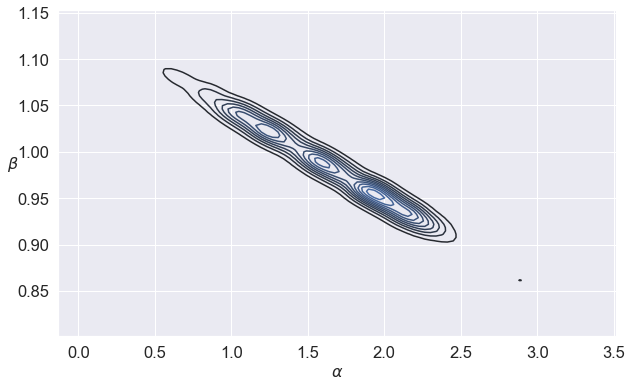

In [8]:
plt.figure(figsize=(10,6))
sns.kdeplot(trace['alpha'], trace['beta'])
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel(r'$\beta$', fontsize=16, rotation=0)

## Does NUTS do better?

In [9]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    #mu = pm.Deterministic('mu', alpha + beta * x)
    #y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    y_pred = pm.Normal('y_pred', mu= alpha + beta * x, sd=epsilon, observed=y)
    step = pm.Metropolis()
    trace = pm.sample(10000, step=step, chains=2)

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>Metropolis: [epsilon]
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:05<00:00, 4092.49draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


### No!

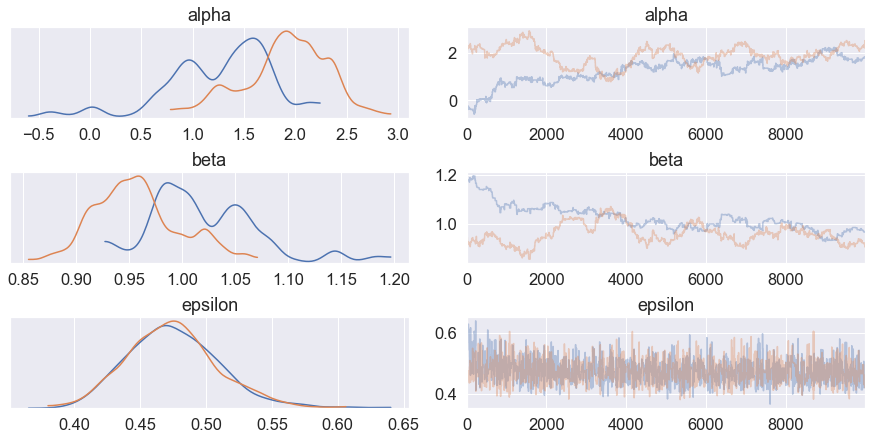

In [10]:
pm.traceplot(trace, compact=True);

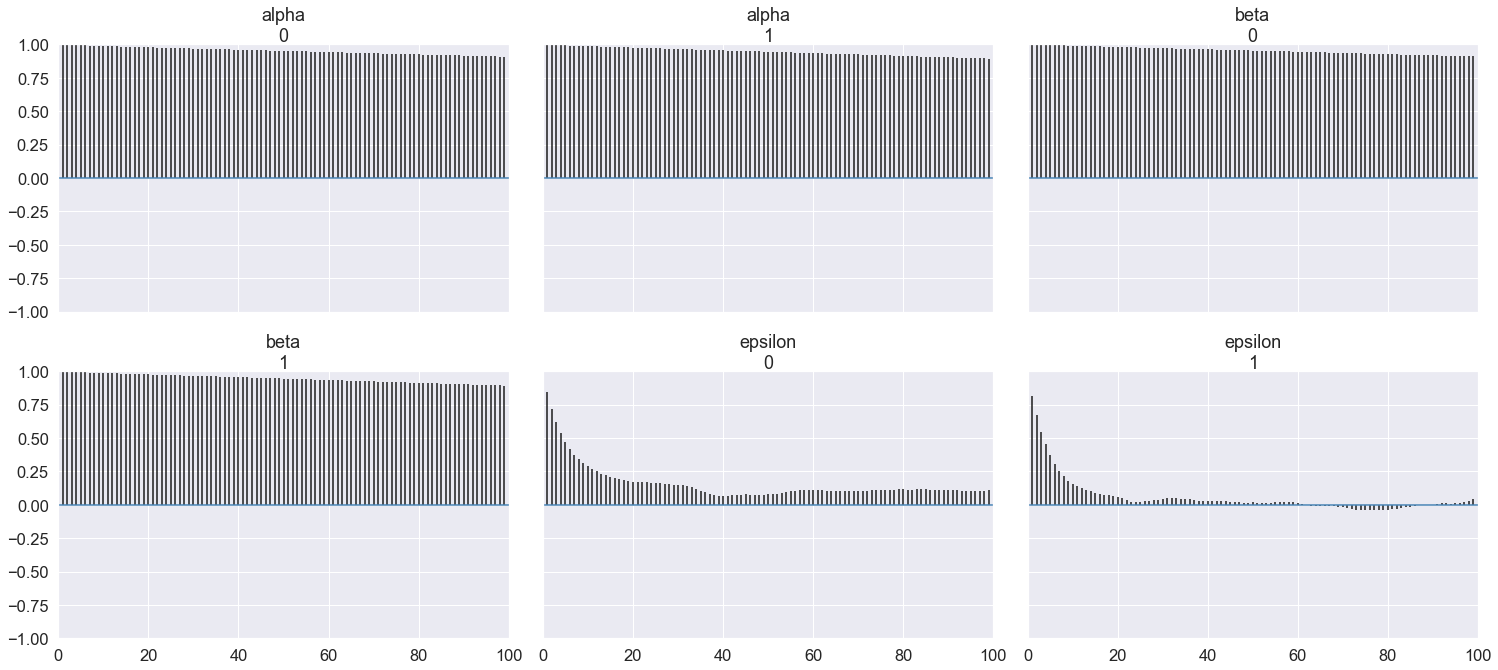

In [11]:
pm.autocorrplot(trace, var_names=('alpha', 'beta', 'epsilon'));

Text(0, 0.5, '$\\beta$')

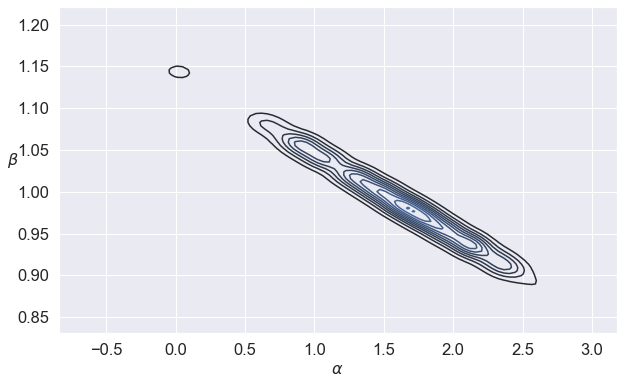

In [12]:
plt.figure(figsize=(10,6))
sns.kdeplot(trace['alpha'], trace['beta'])
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel(r'$\beta$', fontsize=16, rotation=0)

### Try subtracting the mean

In [63]:
xmean = np.mean(x)
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    mu = pm.Deterministic('mu', alpha + beta * (x-xmean))
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    #y_pred = pm.Normal('y_pred', mu= alpha + beta * (x-xmean), sd=epsilon, observed=y)
    #     step = pm.Metropolis()
    step = pm.NUTS()
    trace_n = pm.sample(10000, step=step, chains=2)

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [epsilon, beta, alpha]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:11<00:00, 1767.94draws/s]
The acceptance probability does not match the target. It is 0.8860104617030136, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8800848942003688, but should be close to 0.8. Try to increase the number of tuning steps.


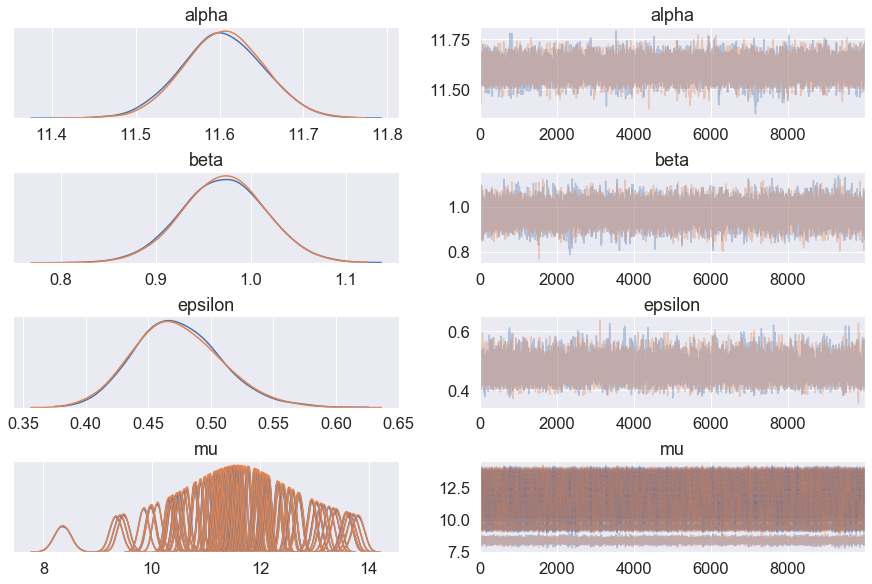

In [64]:
pm.traceplot(trace_n, compact=True);

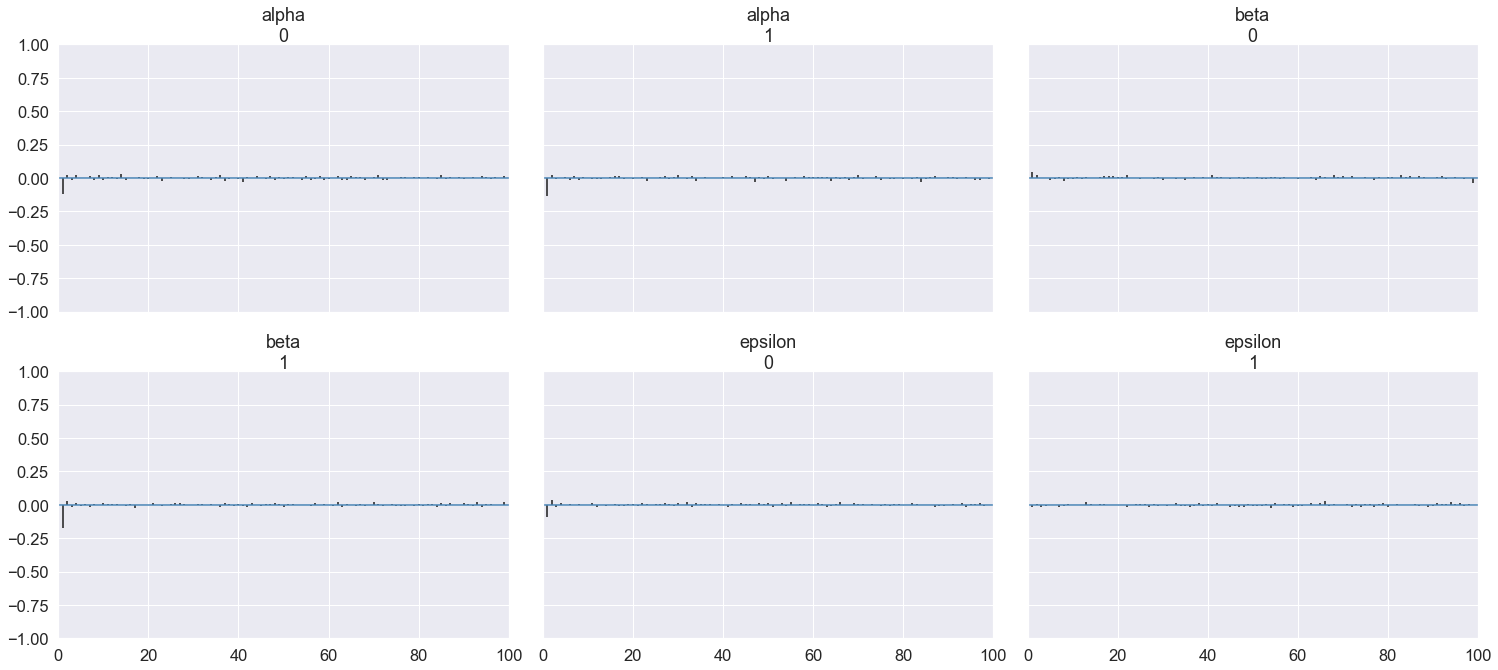

In [65]:
pm.autocorrplot(trace_n, var_names=('alpha', 'beta', 'epsilon'));

Text(0, 0.5, '$\\beta$')

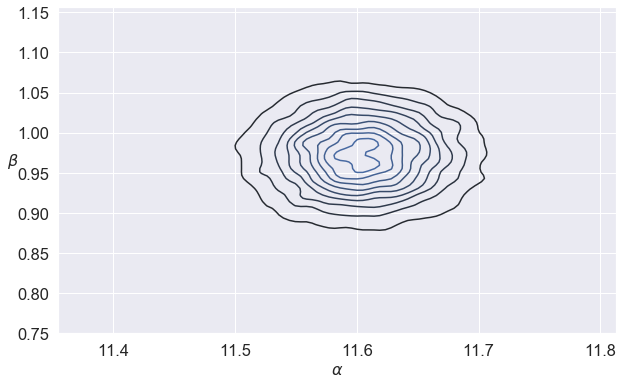

In [66]:
plt.figure(figsize=(10,6))
sns.kdeplot(trace_n['alpha'], trace_n['beta'])
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel(r'$\beta$', fontsize=16, rotation=0)

### Standardize the data 

In [29]:
xp = (x-np.mean(x))/np.std(x)
yp = (y-np.mean(y))/np.std(y)


In [30]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    #mu = pm.Deterministic('mu', alpha + beta * x)`z
    #y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    y_pred = pm.Normal('y_pred', mu= alpha + beta * xp, sd=epsilon, observed=yp)
    step = pm.Metropolis()
    trace = pm.sample(10000, step=step, chains=2)

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>Metropolis: [epsilon]
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:05<00:00, 3955.90draws/s]
The number of effective samples is smaller than 10% for some parameters.


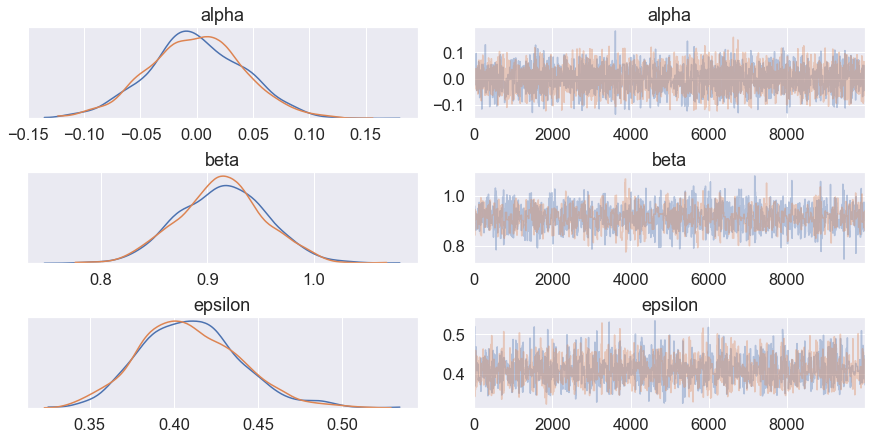

In [31]:
pm.traceplot(trace, compact=True);

Text(0, 0.5, '$\\beta$')

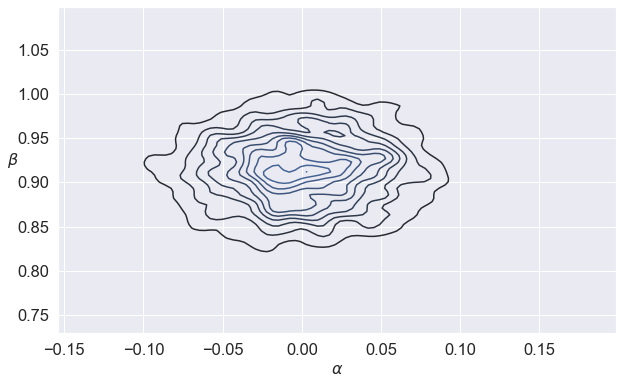

In [32]:
plt.figure(figsize=(10,6))
sns.kdeplot(trace['alpha'], trace['beta'])
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel(r'$\beta$', fontsize=16, rotation=0)

### explore the answer

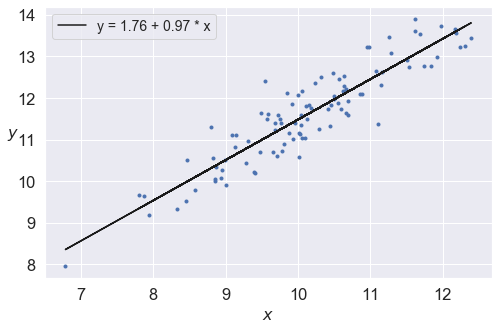

In [67]:
plt.figure(figsize=(8,5))
plt.plot(x, y, 'b.');
beta_m = trace_n['beta'].mean()
alpha_m = trace_n['alpha'].mean()  - beta_m * np.mean(x) # don't forget to rescale

plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend(loc=2, fontsize=14)

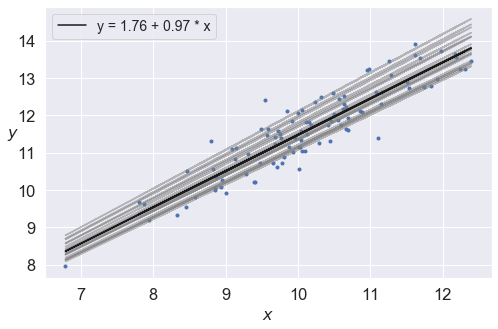

In [69]:
plt.figure(figsize=(8,5))

plt.plot(x, y, 'b.');
idx = range(0, len(trace_n['alpha']), 10)
idx = np.random.randint(0, len(trace_n['alpha']), 20)
plt.plot(x, trace_n['alpha'][idx] - beta_m * np.mean(x) + trace_n['beta'][idx] * x[:,np.newaxis], 
         c='gray', alpha=0.5);
plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend(loc=2, fontsize=14)

For coolness plot out the HPD line shaded. 

Text(0, 0.5, '$y$')

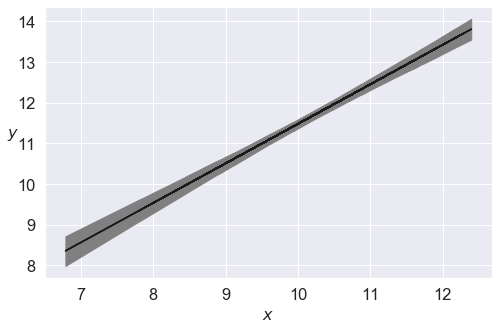

In [71]:
plt.figure(figsize=(8,5))

plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} +{:.2f} * x'.format(alpha_m,beta_m))
idx = np.argsort(x)
x_ord = x[idx]
sig = pm.hpd(trace_n['mu'], alpha=.02)[idx]
plt.fill_between(x_ord, sig[:,0], sig[:,1], color='gray')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)

Or go way cool and plot out the overlap of a couple of them 

100%|██████████| 10000/10000 [00:11<00:00, 850.37it/s]


Text(0, 0.5, '$y$')

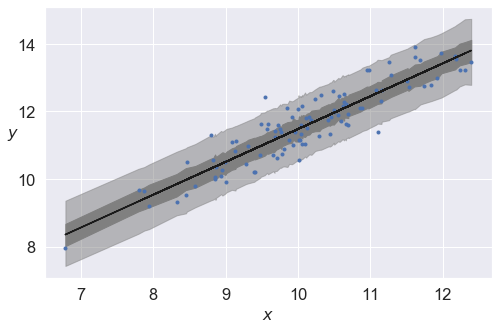

In [79]:
plt.figure(figsize=(8,5))

ppc = pm.sample_posterior_predictive(trace_n, samples=10000, model=model)
plt.plot(x, y, 'b.')
plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))
sig0 = pm.hpd(ppc['y_pred'], alpha=0.5)[idx]
sig1 = pm.hpd(ppc['y_pred'], alpha=0.05)[idx]
plt.fill_between(x_ord, sig0[:,0], sig0[:,1], color='gray', alpha=1)
plt.fill_between(x_ord, sig1[:,0], sig1[:,1], color='gray', alpha=0.5)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)



## Correlation coefficients

In [90]:
with pm.Model() as model_n:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    mu = alpha + beta * x
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    rb = pm.Deterministic('rb', (beta * x.std() / y.std()) ** 2)
    y_mean = y.mean()
    ss_reg = pm.math.sum((mu - y_mean) ** 2)
    ss_tot = pm.math.sum((y - y_mean) ** 2)
    rss = pm.Deterministic('rss', ss_reg/ss_tot)
    step = pm.NUTS(target_accept=0.9)
    trace_n = pm.sample(2000, step=step, )


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [epsilon, beta, alpha]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:15<00:00, 632.32draws/s]


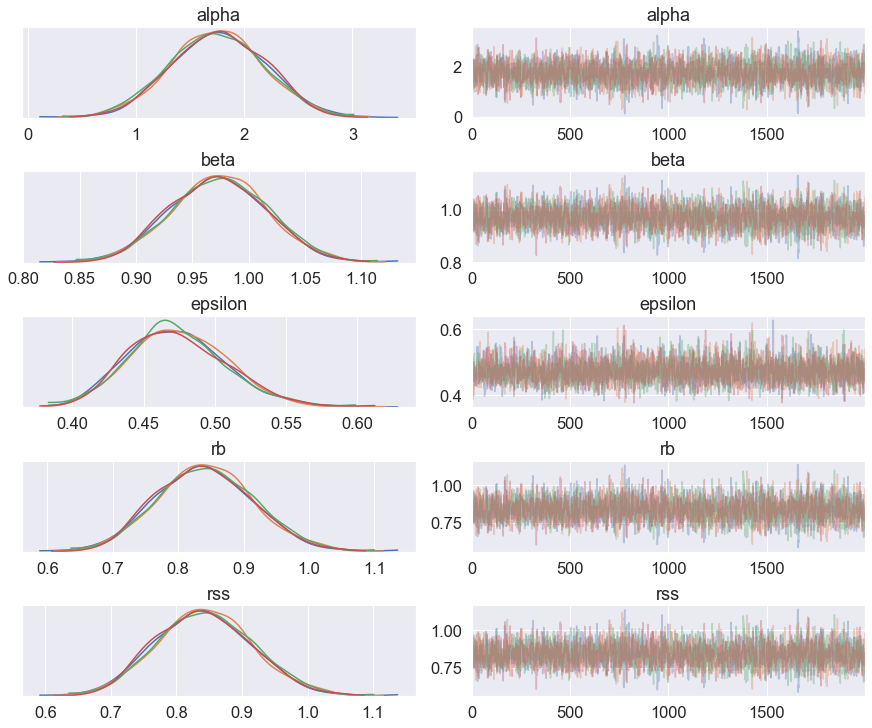

In [91]:
pm.traceplot(trace_n);

In [92]:
pm.summary(trace_n)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,1.746391,0.435683,0.008611,0.899006,2.590308,2709.950268,1.000385
beta,0.973139,0.042708,0.000847,0.890421,1.055760,2717.319498,1.000336
epsilon,0.473792,0.034242,0.000622,0.408336,0.540542,3205.784976,1.000214
rb,0.840801,0.073749,0.001459,0.700415,0.985508,2711.978699,1.000333
rss,0.842455,0.073742,0.001457,0.702737,0.987338,2716.170274,1.000344
